# **Analysis of generated data**

<!-- Analyze dataset results, present findings. The goal is to explore the data and present some business recommendations. We'll also flag some  -->

Explore the dataset, make some business recommendations. Notebook input is data, output is A/B test suggestions.

<!-- ### (!) talk some more about the goal here -->

Links to learn more about the business:
- Restaurant [website](http://thaitanicstreetfood.com/)
- Google [live search results](https://www.google.com/search?q=thai+tanic+sausalito) ([backup](https://github.com/onederekchen/thaitanic/blob/main/data/popular_times/full_view.PNG))
- [Menu backup](https://github.com/onederekchen/thaitanic/blob/main/data/menus/thaitanic_menu_original%2010.2020.pdf) (menu has changed since project debut)

# Setup

### Import libraries

In [1]:
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.options.display.max_rows = 10  # limit huge ouputs
plt.rcParams['figure.figsize'] = (20.0, 10.0)  # set default figsize
plt.style.use('ggplot')  # plt.style.available
warnings.filterwarnings("ignore")  # filter warnings

### Get data

Merge monthly order data into single .csv file. Raw files available on [Github](https://github.com/onederekchen/thaitanic/tree/main/data/raw_data).

In [2]:
path = "../thaitanic/data/raw_data/"

all_months_data = pd.DataFrame()
number_of_files = 0

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])
        number_of_files += 1

all_months_data.to_csv('../thaitanic/data/all_data.csv', index=False)  # don't want to re-save csv every time
print(f"{number_of_files} months of data!")

36 months of data!


In [3]:
df = pd.read_csv("../thaitanic/data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)
df

,Order ID,Item,Quantity Ordered,Price Each,Order Date
0,220826,Yellow Curry,2,12,2019-12-31 20:59:00
1,220809,Nam Kao Tod,2,12,2019-12-31 20:58:00
2,220835,Thai Streetfood Noodle,1,12,2019-12-31 20:55:00
3,220828,Won Ton Soup,2,12,2019-12-31 20:50:00
4,220808,Thai Fried Rice,1,12,2019-12-31 20:50:00
...,...,...,...,...,...
228485,3911,Pad Char,1,15,2017-01-01 12:09:00
228486,3917,Pad See Ew,1,12,2017-01-01 12:08:00
228487,3934,Green Curry,4,12,2017-01-01 12:04:00
228488,3922,Pumpkin Curry,2,15,2017-01-01 12:02:00


### Clean data

In [4]:
df.isnull().sum()  # conveniently clean

Order ID            0
Item                0
Quantity Ordered    0
Price Each          0
Order Date          0
dtype: int64

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.dtypes

Order ID                     int64
Item                        object
Quantity Ordered             int64
Price Each                   int64
Order Date          datetime64[ns]
dtype: object

### Augment data

In [6]:
df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

# Explore data

In [7]:
df.describe()

,Order ID,Quantity Ordered,Price Each,Sales,Year,Month,Weekday Value,Hour
count,228490.000000,228490.000000,228490.000000,228490.000000,228490.000000,228490.000000,228490.000000,228490.000000
mean,112336.111681,1.579483,12.143923,19.192481,2018.005545,6.850317,3.730688,15.874879
std,62621.871087,0.955397,2.904703,12.817808,0.817605,3.495026,1.707090,2.954665
min,3910.000000,1.000000,6.000000,6.000000,2017.000000,1.000000,1.000000,11.000000
25%,58100.250000,1.000000,12.000000,12.000000,2017.000000,4.000000,2.000000,13.000000
50%,112299.500000,1.000000,12.000000,12.000000,2018.000000,7.000000,4.000000,17.000000
75%,166562.750000,2.000000,12.000000,24.000000,2019.000000,10.000000,5.000000,19.000000
max,220837.000000,12.000000,22.000000,198.000000,2019.000000,12.000000,6.000000,20.000000


The lowest Order ID is 3910: maybe Thaitanic started recording data or switched to a new system in December 2016, and just gave us data from January 2017 onwards.  

We're looking at almost 9000 orders per month. With 36 months of data, about 25 open days per month and 8 open hours per day, we're looking at about 350 orders per day, or 40 orders per hour.

At least half of the orders are just a single item, although someone ordered 12!! items. It's probably a business ordering catering, or maybe someone really likes Thai food. No judgement.

The cheapest item is 6 dollars while the most expensive is 22.

### Quantity ordered

Let's check to make sure the 12 orders isn't an error.

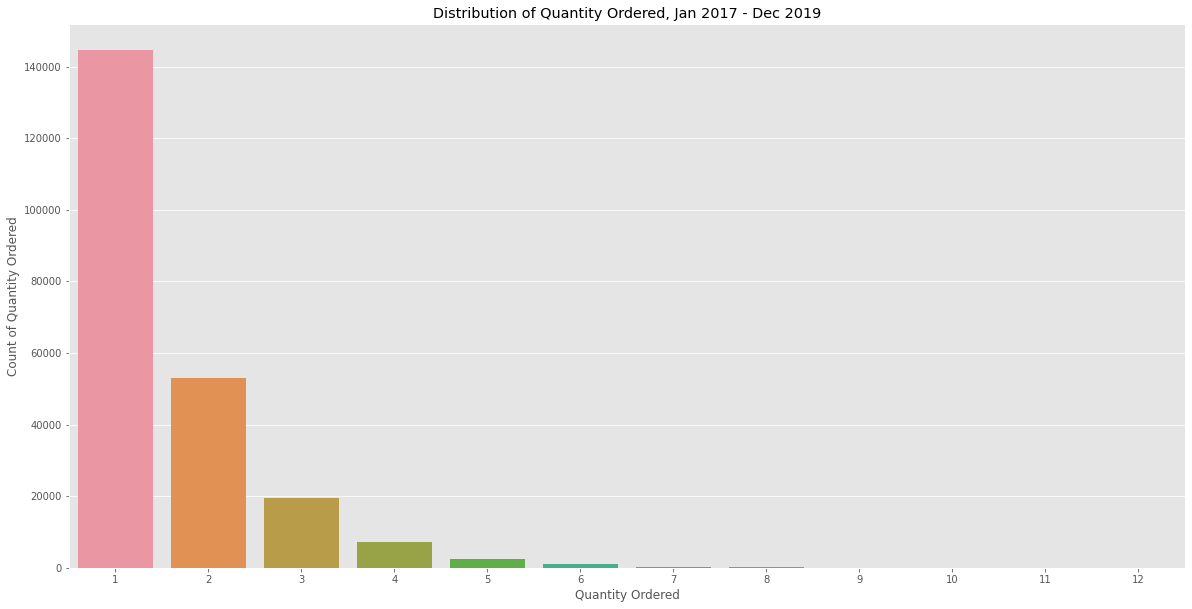

In [8]:
order_distribution = df.groupby('Quantity Ordered').count()

ax = sns.barplot(order_distribution.index, order_distribution['Order ID'])  # column doesn't matter

plt.title("Distribution of Quantity Ordered, Jan 2017 - Dec 2019")
plt.xlabel("Quantity Ordered")
plt.ylabel("Count of Quantity Ordered");

Okay, looks like it really is just a few people ordering a bunch of items. It's a tiny amount compared to 300k+ orders over 3 years.

Let's check which items are the most popular so we can compare it against these bulk orders.

### Item popularity

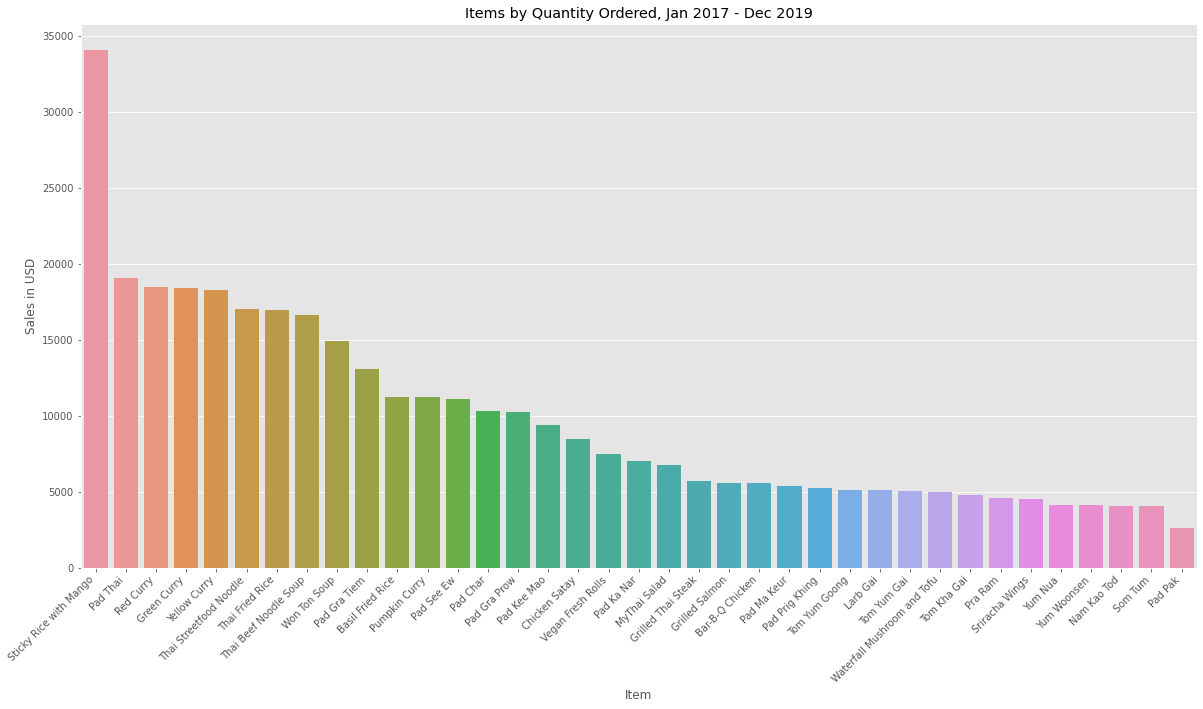

In [9]:
item_popularity = df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

ax = sns.barplot(item_popularity.index, item_popularity['Quantity Ordered'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Items by Quantity Ordered, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

Some observations:
- There's a LOT of menu items, and a significanty drop off in popularity
- Everybody loves sticky rice with mango
- Some categories of items are really popular (like curries and soups)
- Items with non-English names seem to be less popular

We don't have expense information, but we could probably save a bunch of money by removing items from the menu. It's expensive to stock a big menu, and not that risky to remove it: if we get rid of an item, do we think it will cause a customer to eat elsewhere, or to just order something else? Does it even help us to have such a big menu in the first place?

It also seems like an easy change to add English names (would be really easy to test too).

Let's compare against sales next.

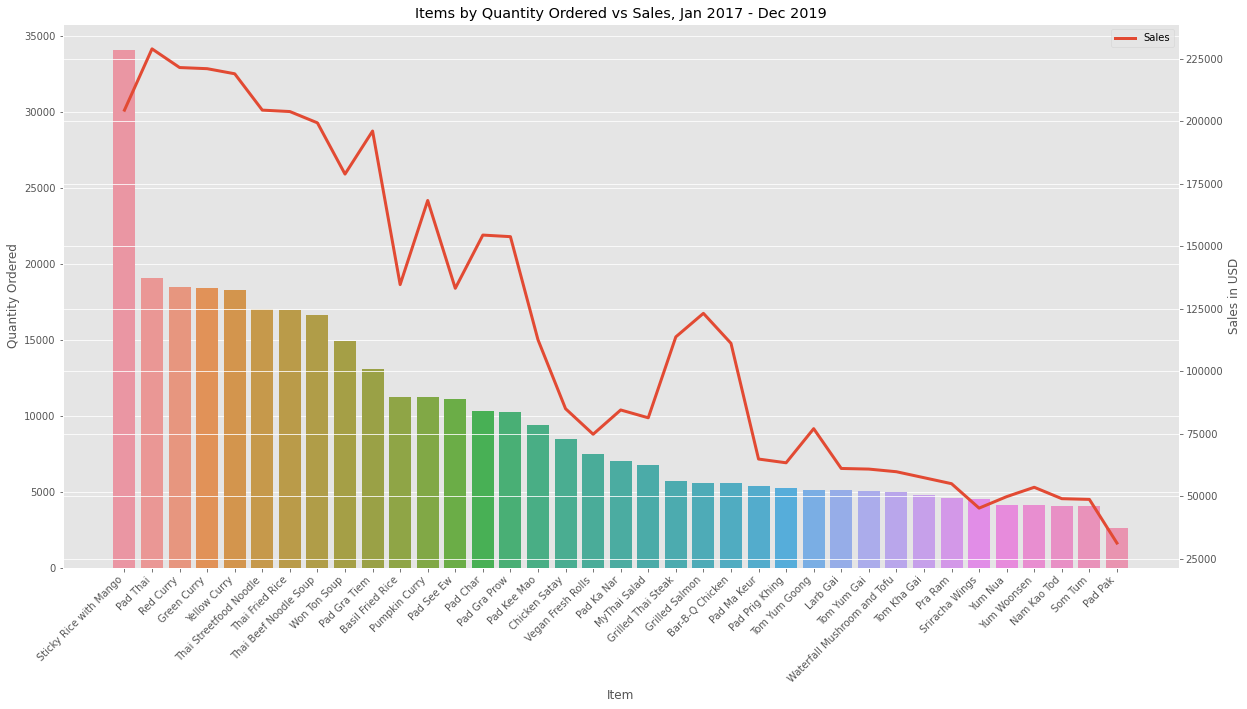

In [10]:
ax = sns.barplot(item_popularity.index, item_popularity['Quantity Ordered'])

ax2 = ax.twinx()
sns.lineplot(item_popularity.index, item_popularity['Sales'], label='Sales', linewidth=3)  # consider increasing thickness, changing color

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Items by Quantity Ordered vs Sales, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

More observations:
- Interesting that the most sold item isn't the one generating the most profit - sticky rice is only 6 dollars.
- The curries and soups are top tier popularity and sales. 
- There's a dip around appetizers (since they don't cost as much), but they aren't as popular as the sticky rice.
- The BBQ items are expensive... combo them with something to sell more?
- Seriously consider adding English names to the Thai dishes, some of these are so slept on.

Sales is quantity ordered times the price. So even though sticky rice is the most popular, it doesn't make as much money as other dishes because it's cheap. It's only six dollars per dish.

Let's check it against those big orders from earlier.

<!-- (!) might be interesting to group this by menu type... 

Note on increasing number of orders: Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too. 

Could evaluate tradeoffs in order quantity vs price: e.g. if sticky rice was ten dollars, what percentage of customers could we afford to lose?
... this is business recs that are beyond the point though. focus on the main idea here. 

-->

### Check against big orders

Let's check against those big orders from before to found out our product exploration.

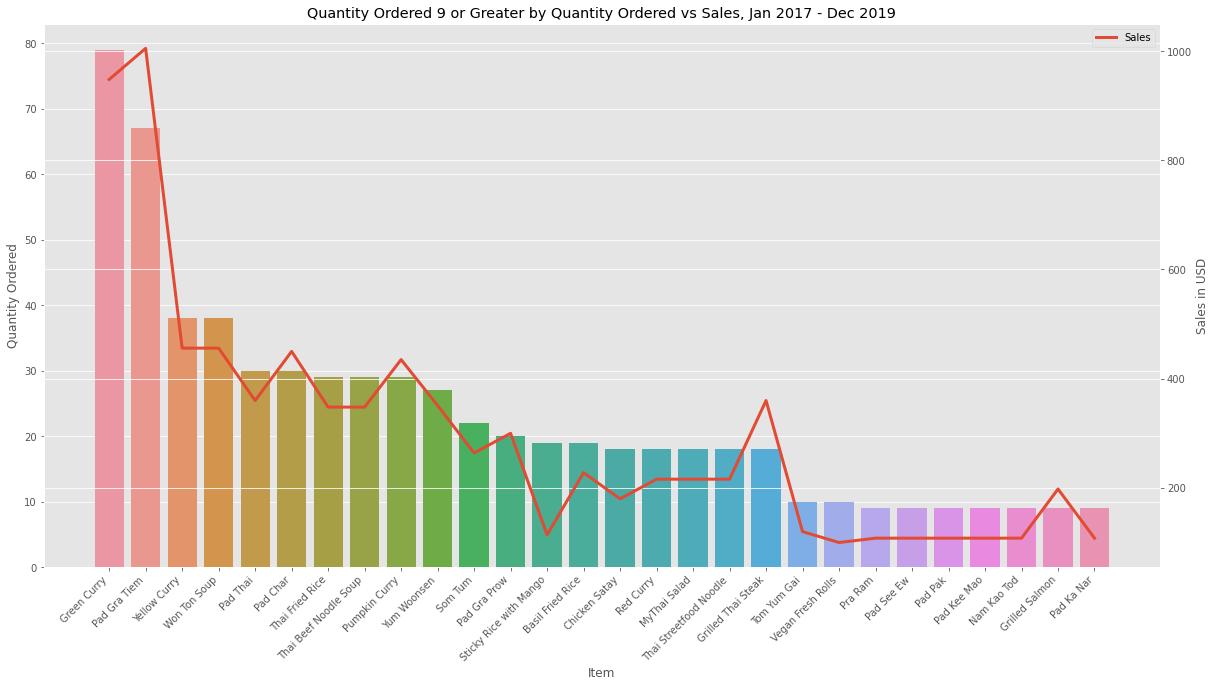

In [11]:
big_orders = df.loc[(df['Quantity Ordered'])>=9]
grouped_big_orders = big_orders.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

ax = sns.barplot(grouped_big_orders.index, grouped_big_orders['Quantity Ordered'])

ax2 = ax.twinx()
sns.lineplot(grouped_big_orders.index, grouped_big_orders['Sales'], label='Sales', linewidth=3)  # consider increasing thickness, changing color

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Quantity Ordered 9 or Greater by Quantity Ordered vs Sales, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

I just picked 9 because a group of 6 doesn't seem unusual. Rare, but not really unusual. Would be cool if we had data on whether it was eat-in or takeout.

Comparing this to all of the data, there doesn't seem to be a big difference. The orders are changed around, but for the most part the popular items are still popular and the unpopular items are still unpopular. It does look like there's relatively less sticky rice with mango purchases. So unfortunately nothing promising in big orders.

Next let's look at what items people are buying together.

### Multiple items in one order

In [12]:
dupes_df = df.loc[(df['Order ID'].duplicated(keep=False))]
dupes_df

,Order ID,Item,Quantity Ordered,Price Each,Order Date,Sales,Year,Month,Weekday,Weekday Value,Hour
11,220806,Sticky Rice with Mango,1,6,2019-12-31 20:36:00,6,2019,12,Tuesday,1,20
12,220806,Sticky Rice with Mango,1,6,2019-12-31 20:36:00,6,2019,12,Tuesday,1,20
38,220786,Sriracha Wings,1,10,2019-12-31 19:56:00,10,2019,12,Tuesday,1,19
39,220786,Sticky Rice with Mango,1,6,2019-12-31 19:56:00,6,2019,12,Tuesday,1,19
56,220787,Vegan Fresh Rolls,1,10,2019-12-31 19:25:00,10,2019,12,Tuesday,1,19
...,...,...,...,...,...,...,...,...,...,...,...
228451,3960,Pad Kee Mao,2,12,2017-01-01 13:12:00,24,2017,1,Sunday,6,13
228464,3932,Sticky Rice with Mango,1,6,2017-01-01 12:58:00,6,2017,1,Sunday,6,12
228465,3932,Sticky Rice with Mango,1,6,2017-01-01 12:58:00,6,2017,1,Sunday,6,12
228469,3927,Won Ton Soup,2,12,2017-01-01 12:49:00,24,2017,1,Sunday,6,12


Looks like additional items in the same order are listed as another line with the same Order ID.

Let's see if the dupes are any different than the individual products.

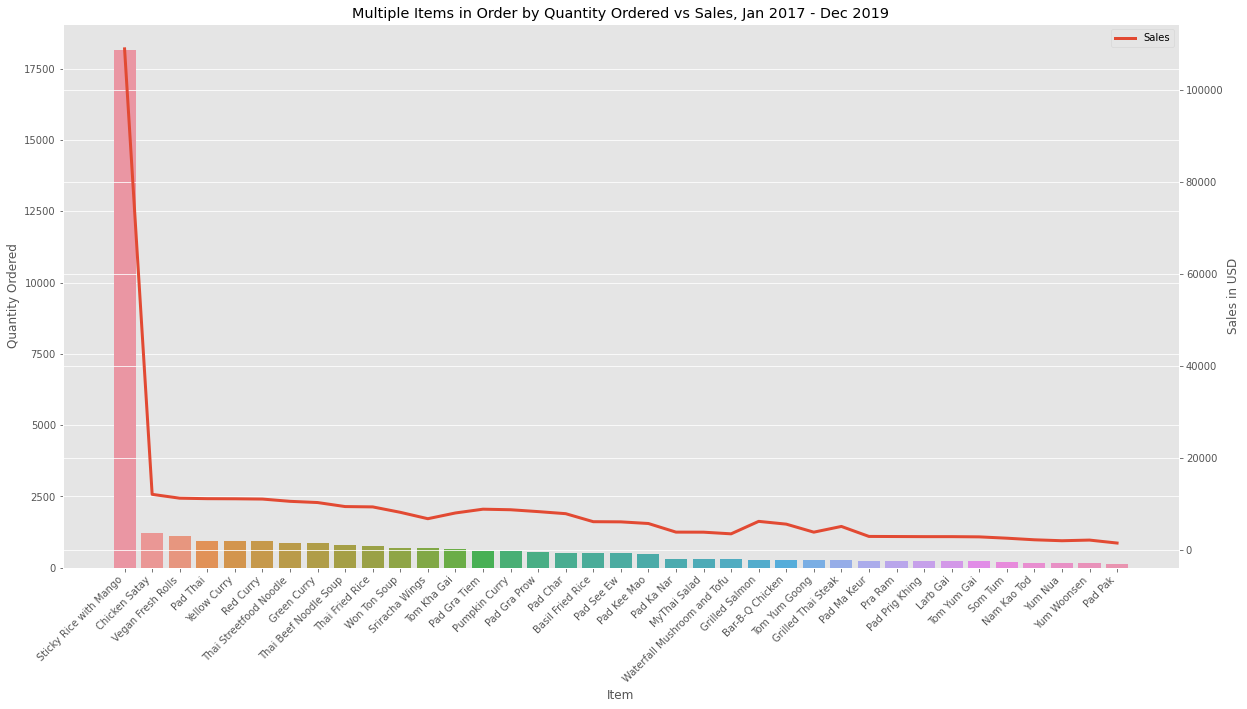

In [13]:
dupes_popularity = dupes_df.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

ax = sns.barplot(dupes_popularity.index, dupes_popularity['Quantity Ordered'])

ax2 = ax.twinx()
sns.lineplot(dupes_popularity.index, dupes_popularity['Sales'], label='Sales', linewidth=3)  # consider increasing thickness, changing color

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Multiple Items in Order by Quantity Ordered vs Sales, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

Wow, that's a huge jump. I guess it makes sense because most people who eat a meal will be full. And then the dessert is nice and also not very expensive.

Things appear to be relatively even (following their item popularity from before) except for sticky rice with many which is way high. Also, the next most popular items are appetizers, which were ranked very low otherwise.

For completeness, let's also look at orders not paired with sticky rice and mango.

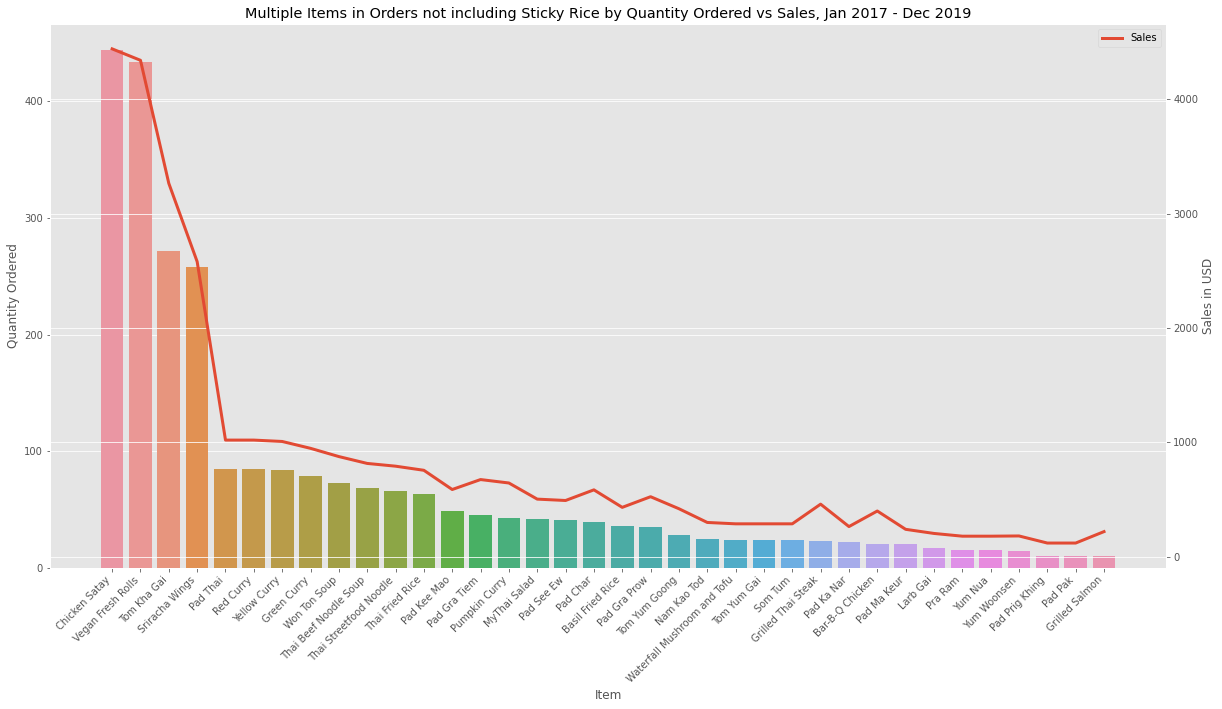

In [14]:
dupes_no_sticky_rice = df.loc[(df['Order ID'].duplicated(keep=False) & ~(df['Item'].str[0:6]=="Sticky"))]
remaining_dupes = dupes_no_sticky_rice.loc[(dupes_no_sticky_rice['Order ID'].duplicated(keep=False))]
grouped_remaining_dupes = remaining_dupes.groupby('Item').sum().sort_values(by='Quantity Ordered', ascending=False)

# plt.figure(figsize=(12,9))
ax = sns.barplot(grouped_remaining_dupes.index, grouped_remaining_dupes['Quantity Ordered'])

ax2 = ax.twinx()
sns.lineplot(grouped_remaining_dupes.index, grouped_remaining_dupes['Sales'], label='Sales', linewidth=3)  # consider increasing thickness, changing color

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Multiple Items in Orders not including Sticky Rice by Quantity Ordered vs Sales, Jan 2017 - Dec 2019")
plt.ylabel("Sales in USD");

So not including sticky rice, it looks like people also pair appetizers (it was just hard to see because of how much people like sticky rice). 

It looks like the rest of the distribution follows the item popularity. Let's quantify it quickly.

In [15]:
# show number of appetizers in duplicate orders
len(remaining_dupes.loc[(remaining_dupes['Item'].str[0:5]=="Tom K") | 
                   (remaining_dupes['Item'].str[0:5]=="Srira") | 
                   (remaining_dupes['Item'].str[0:5]=="Chick") | 
                   (remaining_dupes['Item'].str[0:5]=="Vegan")]
   )

908

In [16]:
# duplicate pairings not including an appetizer (740)
len(remaining_dupes.loc[~(remaining_dupes['Item'].str[0:5]=="Tom K") & 
                   ~(remaining_dupes['Item'].str[0:5]=="Srira") & 
                   ~(remaining_dupes['Item'].str[0:5]=="Chick") & 
                   ~(remaining_dupes['Item'].str[0:5]=="Vegan")]
   )

788

So excluding desserts, the FOUR appetizers are paired more frequently than every other dish.

##### So our finding is that people very frequently frequently add the dessert the dessert to their order, and people pair the appetizers more than normal meals (but far less than the desserts).

Maybe we can include this as a combo to encourage people to buy more expensive items, or to buy appetizers which don't seem to be especially popular as a pairing.

### Recap product recommendations

I feel fine with this for an initial exploration. We could go on forever, but we already have some solid recommendations. Note that we are specifically looking to maximize sales (if we had expense information, we would be trying to maximize profit too).

<!-- **Business recommendations** -->

- Consider adding English names to the menu.

- Consider raising the price of sticky rice? (tests elasticity...)

- Consider offering combo meals w/ appetizers and profitable meals (perhaps pairing sticky rice and an appetizer with the profitable bbq items).

<!-- The two ways to increase revenue are to get more customers into the restaurant, or to get customers already in the restaurant to spend more. If offering -->

- Consider removing some of the less popular dishes from the menu.

<!-- What combos can we offer? (i'm too tired to figure it out right now... probably pair sticky rice and/or an app w/ bbq items) -->

<!-- **Test recommendations** -->

<!-- In a testing scenario, we would want to test -->

<!-- ...(!) I actually think about it better in terms of slides... -->



Maybe try this analysis a bit further down.

# Best, worst months of sales?

Now that we're familiar with the products, let's check out sales.

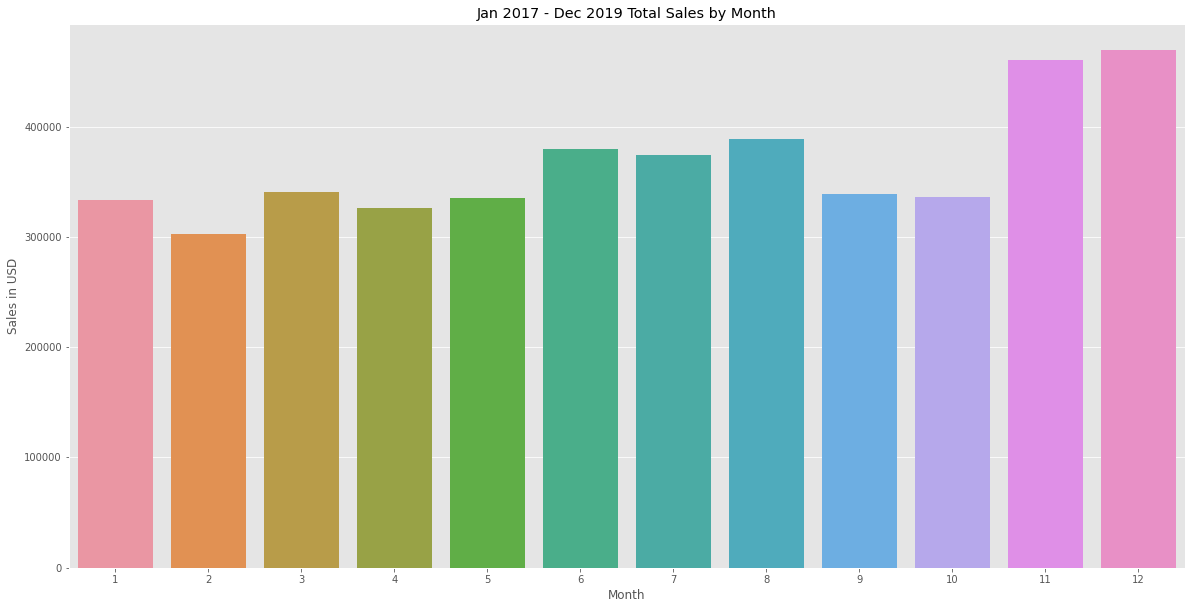

In [32]:
month_total_sales = df.groupby('Month').sum()

ax = sns.barplot(month_total_sales.index, month_total_sales['Sales'])

plt.title("Jan 2017 - Dec 2019 Total Sales by Month")
plt.ylabel("Sales in USD");

This just shows gets us an idea of how much money we're looking at. It's cumulative months, so we'll probably look by month by year in a bit. But this is a quick way to get a picture of where things are.

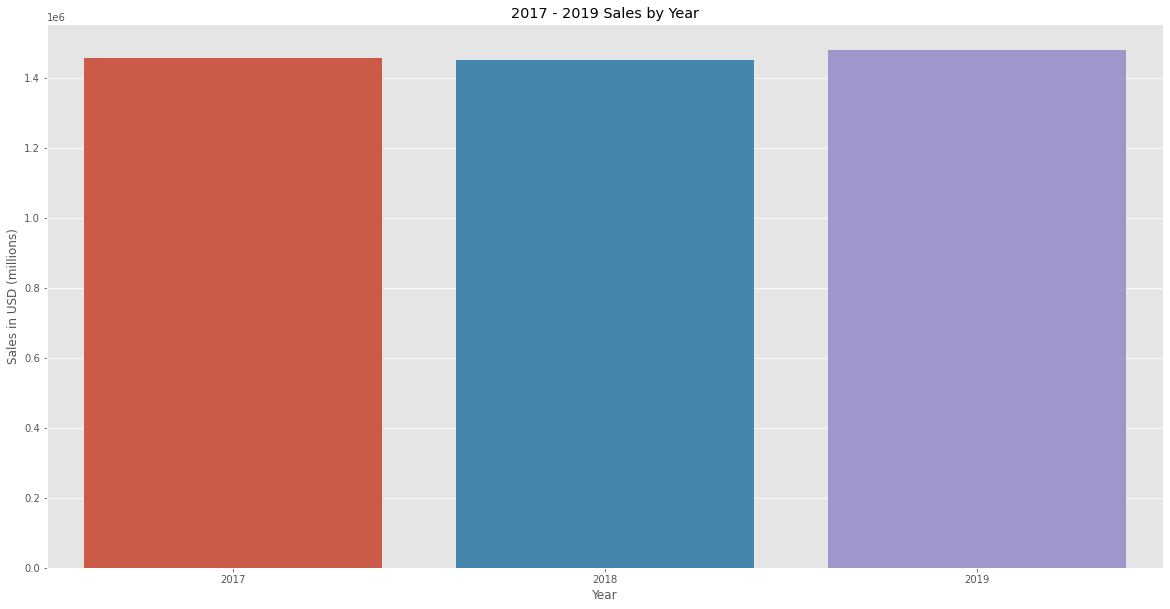

In [33]:
year_sales = df.groupby('Year').sum()

# plt.figure(figsize=(8,6))
ax = sns.barplot(year_sales.index, year_sales['Sales'])

plt.title("2017 - 2019 Sales by Year")
plt.ylabel("Sales in USD (millions)");

In [41]:
year_sales['Sales'][2019]/year_sales['Sales'][2017]/100

0.01014896134774945

Sales look similar between years. Trending upwards, but not significantly enough to note. 2019's sales are about 1% higher than 2017's.

This isn't a new restaurant, so it's likely the demand has settled to the market. It's beyond the scope of this analysis, but you could look at trends for other restaurants in the area to get an idea of how much the area affects sales (as opposed to effort from the restaurant team). 

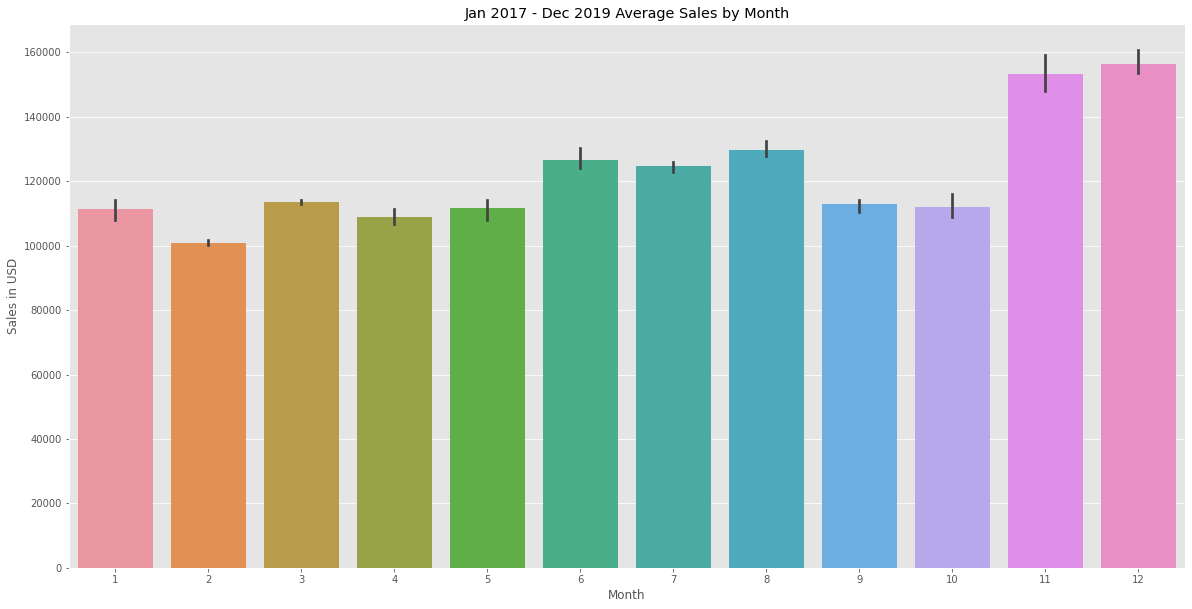

In [42]:
month_sales = df.groupby(['Year', 'Month']).sum().reset_index()

ax = sns.barplot(data=month_sales, x='Month', y='Sales')

plt.title("Jan 2017 - Dec 2019 Average Sales by Month")
plt.ylabel("Sales in USD");

# check: most of the highest values are from 2019
# sales_2019 = df.loc[(df['Year']==2019)]
# month_sales_2019 = sales_2019.groupby('Month').sum()
# ax = sns.pointplot(month_sales_2019.index, month_sales_2019['Sales'], marker='.', join=False)

This shows us the average sales per month, as well as the highest and lowest recorded in any year. Note that most of the highest values are from 2019, as the restaurants business has been trending (slightly) upwards.

We mostly see that November and December are significantly higher, and that the summer months are slightly higher. February looks really low, but it might just be because it has slightly less days.

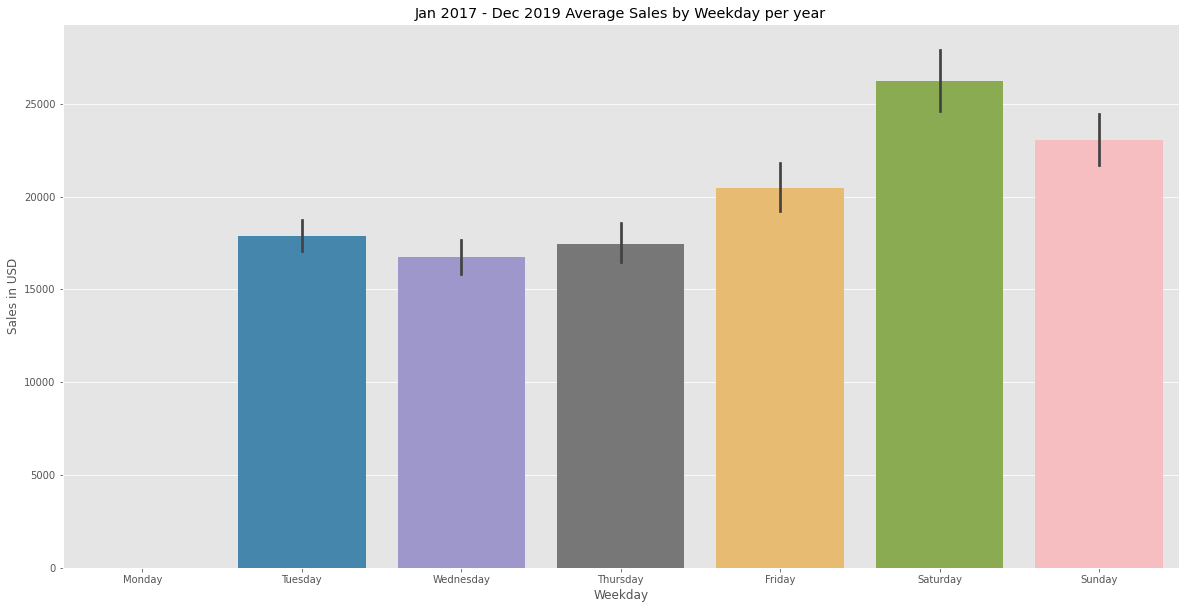

In [51]:
# average weekday sales with range  # (!) this graph is wrong, should show mean instead
weekday_sales_without_monday = df.groupby(['Year', 'Month', 'Weekday Value', 'Weekday']).sum().reset_index()
weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)

monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed
weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

ax = sns.barplot(data=weekday_sales, x='Weekday', y='Sales')

plt.title("Jan 2017 - Dec 2019 Average Sales by Weekday per year")
plt.ylabel("Sales in USD");

From looking at the weekdays, we see that Wednesdays are pretty consistently the least popular days of the week. There's a dip, so could we add money by opening on Mondays instead of Wednesdays?

(!) Note these are really ranges, not confidence intervals. 

#### So the hypothesis is that opening on Mondays instead of Wednesdays will increase sales by X amount. We will open on Mondays for a month, and afterwards will consider it a success if the Monday sales are in X range.

If we make more money over the course of a month on Mondays than we do on Wednesdays, that's obviously a good thing. We can value the experiment by taking the the change in revenue from Monday/Wednesday minus the amount of effort/labor that went into the experiment.
--> evaluate these differences in the experiments notebook.

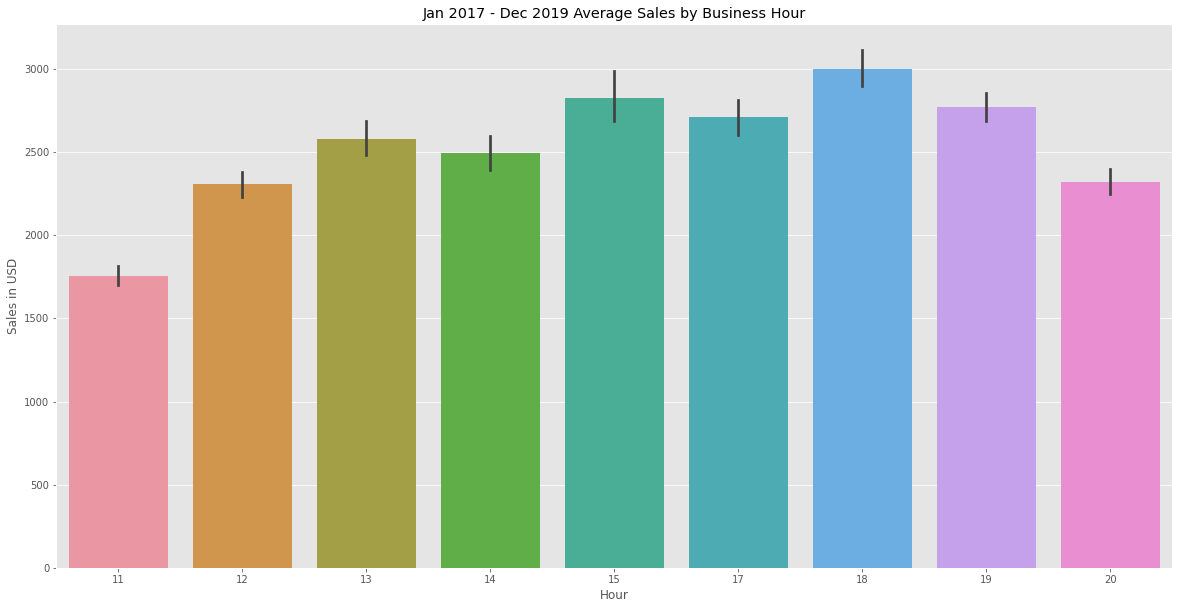

In [46]:
# it might even be a waste of space to even include this visualization.

hour_sales = df.groupby(['Year', 'Month', 'Weekday', 'Hour']).sum().reset_index()

ax = sns.barplot(data=hour_sales, x='Hour', y='Sales')

plt.title("Jan 2017 - Dec 2019 Average Sales by Business Hour")
plt.ylabel("Sales in USD");

This gives averages, which is fine because we have so many data points, but isn't helpful aside from showing us that the early lunch hours are the least profitable. Maybe they should just be open from 12-4 every day instead of being open from 11-3 on weekdays. That would also be pretty easy to test.

Let's look at the hours for each day instead though.

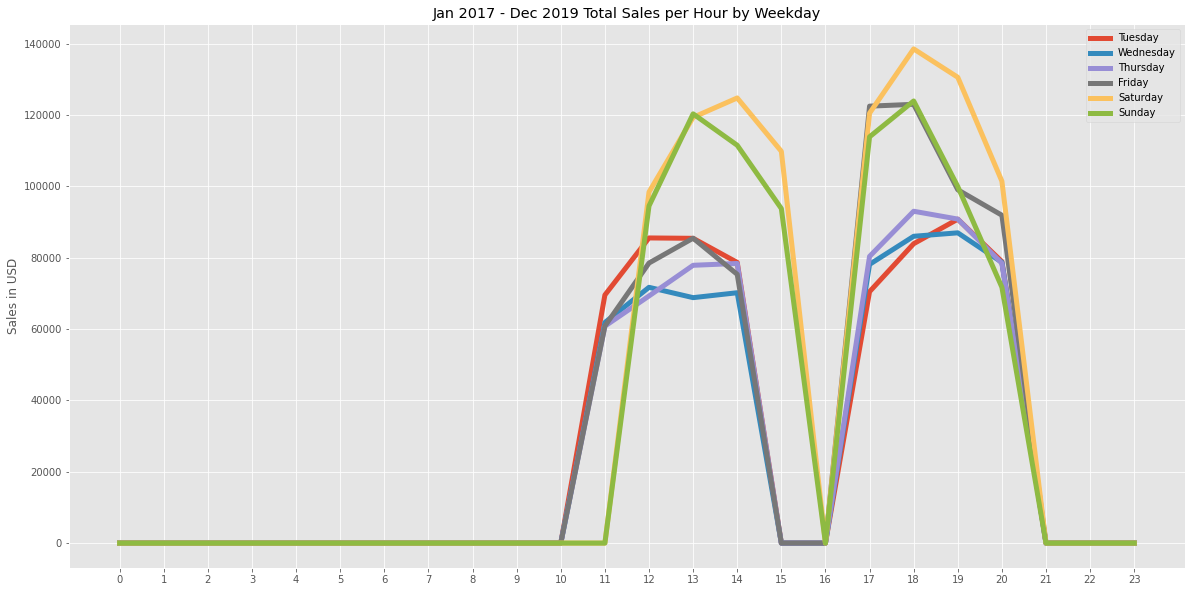

In [45]:
weekdays = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for weekday in weekdays:
    day_sales_filtered = df.loc[(df['Weekday'] == weekday)]
    day_sales = day_sales_filtered.groupby('Hour').sum()
    day_values = []
    for hour in range(0,24):
        if hour not in day_sales.index:
            day_values.append(0)
        else:
            day_values.append(day_sales["Sales"][hour])
    ax = sns.lineplot(x=range(0,24), y=day_values, label=weekday, linewidth=5)

plt.xticks(list(range(24)))
plt.ylabel("Sales in USD")
plt.title("Jan 2017 - Dec 2019 Total Sales per Hour by Weekday");

# plt.savefig("2019_Sales.png", dpi=100, bbox_inches='tight')

We can see here that Wednesday is pretty much the lowest day (even lower than Tuesday or Thursday), so maybe switching the off day from Monday to Wednesday might be something to try.

At a glance, you might consider changing up weekday hours from 11am-3pm to 12pm-4pm since the sales are higher there. But we can be pretty sure that weekend hours and customer availability are much better on weekends.

# Let's recap our suggestions

Maybe remove the least purchased dishes from the menu? Would need some information on how expensive it is to stock/prepare each item, but the business could become more lean this way.

(?) What's the value prop? Is it important to have such variety, or could they focus on doing a few dishes really really well?

Maybe pair the most popular dish with some less popular dishes (to encourage people to try other stuff).

Alternatively, you could pair the most popular dish as a combo with even more popular dishes to get people to buy more. But you might be able to increase overall demand like this. The Bay Area has foodie culture, and if you're known for top tier Thai food and good prices, people will make the trip. In this case, you might want to consider some marketing stuff too.

### Conceptualize restaurant revenue model --> move downwards after exploration complete!

### (?) We can use a conceptual model of the restaurant's revenue to check we haven't missed anything huge.

Now that we've seen the data, let's build a basic business model so we have an idea of what to look for. The restaurant's revenue model can be conceptualized as a product of two major factors:
1. How many people eat at the restaurant? (How many orders will it get?)
2. What do those customers eat? (How much is each order worth?)

We can create a basic revenue model by considering the drivers of those two factors. (Red notes drivers we can directly affect). 

<!-- ![](revenue_model.jpg) -->

Here are some questions that might be helpful to think about during our initial exploration:
* What hours are the best? (check against sales and orders)
* What items are the most popular? (We can try combo meals instead of simply dropping prices)
##### (?) if we increase value offered, will the cost/order go up?

It's out of scope for this notebook, but you could also consider deeper analysis such as:
* Market trends in the area
* Competitive analysis on other restaurants in the area, especially Thai restaurants
* Does the ordering of the menu items affect the menu?

# A/B Test suggestions

1. Close on Wednesdays instead of Mondays (if you were really worried, you could try staying open 7 days/week, but I recognize that's not realistic).
2. Offer combos? (pair w/ marketing of value proposition)

# Non-test recommendations (!) Give insights, ordered recommendations, and suggestions for things to test.

1. Stop offering so many items.
2. Note which items are vegan/vegetarian.
3. Consider hiring help to be open for more hours (instead of closing during the day)

It looks way important to be open for December. Run a calculation that shows just how important. Seriously, hire seasonal help. 


Note on combos: Offering combos increases the value proposition, which might increase the sales from customers who are already in the restaurant. But to really make it worth it (cost-benefit analysis the 'worth-it' here because it might be worth it with that alone), you would want to engage in some kind of marketing, or way to amplify the customers who make it to your store. Marketing your value proposition.

In the next notebook, we'll look at experimental design and assume we weren't the one who did the analysis role.

### Other stuff to add in the future

These are low priority things that are are a bit out of scope, since we already have a bunch of high priority recommendations.
- time series forecast on revenue

# NOTES

I'm just exploring the data. Is there anything specific I can already look for?

1. Sales (break down by times?)

(?) should PRODUCT column just be 'Order' or 'Item'?

(!) order date is time accurate, not order ID... woops.